In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib notebook

plt.style.use("classic")
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.facecolor'] = '#EEEEEE'
plt.rcParams["font.sans-serif"] = ["Helvetica"]
plt.rcParams["axes.xmargin"] = 0.05
plt.rcParams["axes.ymargin"] = 0.05
plt.rcParams["figure.constrained_layout.use"] = True
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["image.cmap"] = "gnuplot"

# Helper functions

In [2]:
def make_data(N=2000, p=0.05):
    # N : number of data points
    # p : chance that a point closer to one center has the color of the other
    
    # make centers and save them if they don't already exist
    if not (hasattr(make_data, "c0")):
        make_data.c0 = np.random.uniform(-1, 1, 2)
        make_data.c1 = make_data.c0 + np.random.uniform(-1, 1, 2)
    c0 = make_data.c0
    c1 = make_data.c1
    
    # set initial labels
    y = np.random.randint(0, 2, N)
    
    s = np.linalg.norm(c0 - c1)/3
    # X is a 50/50 mixture of Gaussians, according to y
    X = np.array([c0, c1])[y] + np.random.normal(0, s, (N, 2))
    
    # Now edit y so that each point has the color of the closer center
    y = np.int64(
        np.linalg.norm(c1 - X, axis=1) > np.linalg.norm(c0 - X, axis=1)
    )
    # flip labels uniformly with chance p
    ii = np.random.uniform(0, 1, N) < p
    y[ii] = 1 - y[ii]
    return X, y

In [3]:
def test(f):
    # make_data makes random centers the first time it's run, but it saves
    # them so this call has the same centers but different points
    X, y = make_data()
    y_estimate = np.array([f(x) for x in X])
    accuracy = np.mean(y == y_estimate)
    return accuracy

# Binary classification in two dimensions

In the plot below, the red dots are sampled from a certain distribution and the blue dots are sampled from a different distribution. The coordinates of the dots are in the $N\times 2$ matrix $X$ and the colors are in the $N$-vector $y$, 1 for red and 0 for blue.

In [4]:
X, y = make_data()

<IPython.core.display.Javascript object>


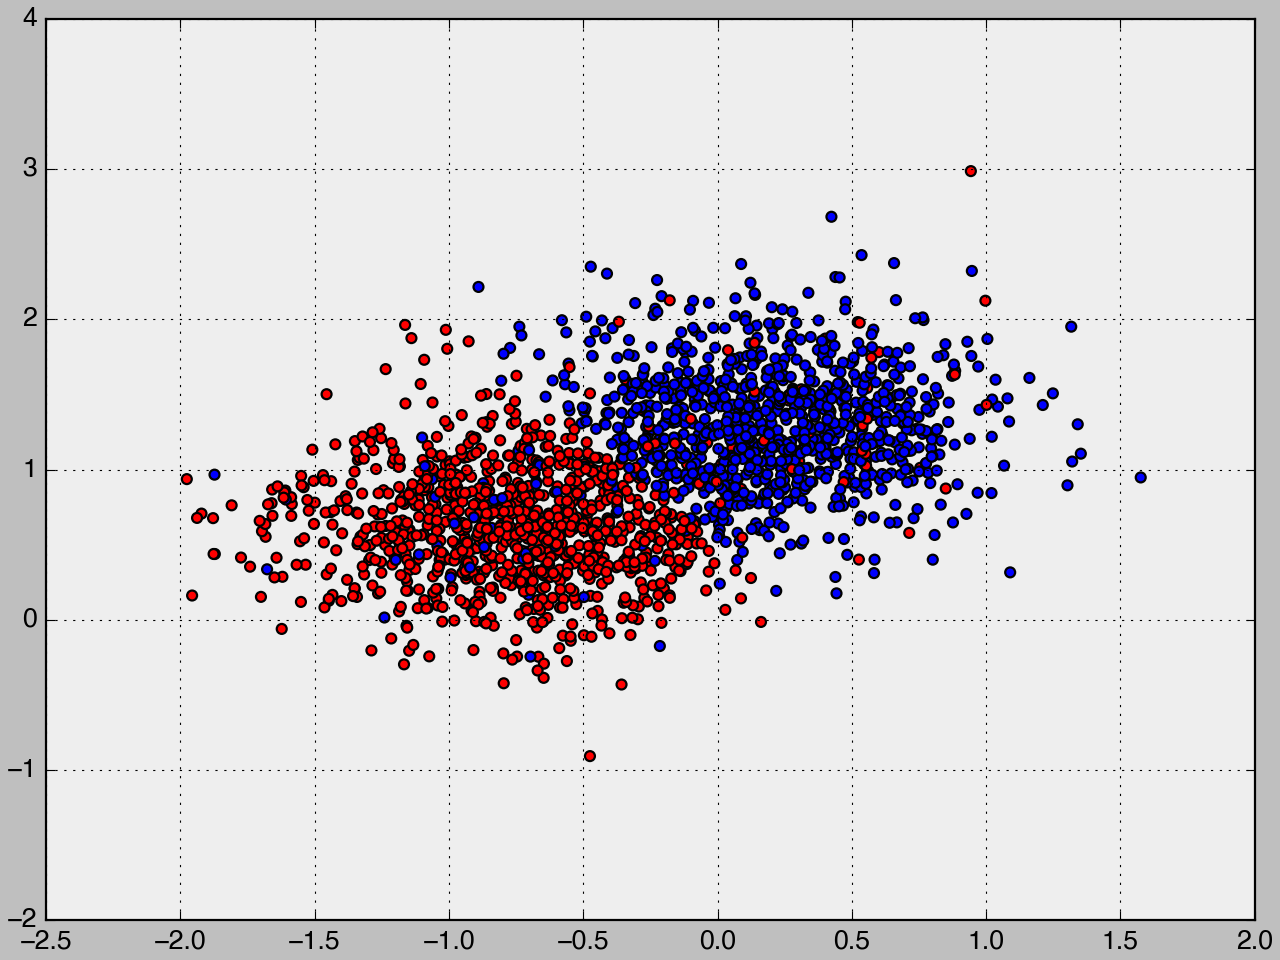

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 1], c=np.array(["b", "r"])[y])

Use $X$ and $y$ to create a function that takes a new sample's coordinates and produces a guess as to the sample's color. For example, if our strategy is to compare the first coordinate with `mean(X[:, 0]) - 30` (a bad strategy), the function might look like:

In [6]:
mx = np.mean(X[:, 0])
def example_classify(x):
    return x[0] > mx - 30

Test your function with the function called `test`:

In [7]:
test(example_classify)

0.5035

Our sad example only gets the right answer about half the time, no better than random guessing! Your function should be able to get the right answer at least 90% of the time. Use the space below for scratch calculations and then create your function and test it.

# Solution

There is more than one right way to solve this problem. Here are two.

## 1: knn

In [8]:
def knn(x, k=5):
    nn = np.argsort(np.linalg.norm(X - x, axis=1))
    return np.round(np.mean(y[nn[:k]]))

In [9]:
test(knn)

0.9475

## 2: Linear discriminant

Linear discriminant analysis is simply linear regression on the class labels. This might sound too simplistic to work, but it can work surprisingly well and it's easy to train and test.

In [10]:
# w is the least squares solution to [X | 1] w = y
w = np.linalg.lstsq(
        np.hstack((X, np.ones((len(X), 1)))), # stack X with ones to get const
        2*y-1, # transform y to +/- 1
        rcond=None)[0] # "rcond=None" is just numpy boilerplate

In [11]:
# w has three terms since X has two dimensions and there is a constant term
w

array([-0.87467111, -0.6325634 ,  0.35123402])

In [12]:
def lda(x):
    x1 = np.concatenate((x, [1]))
    return x1 @ w > 0

In [13]:
test(lda)

0.9515